<a href="https://colab.research.google.com/github/jefffang19/image_processing_final/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework requirement:
pytorch == 1.6.0

In [1]:
!python --version

Python 3.6.9


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 38.2MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [4]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 37.6MB 84kB/s 
     |████████████████████████████████| 952kB 45.7MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
# if use google colab, mount your drive

from google.colab import drive
drive.mount('/content/gdrive')

dataset_path = F"/content/gdrive/My Drive/ip_final/data/train"

Mounted at /content/gdrive


# The structure of the dataset

```
0 (patient)
  |
  | -|- CT => mask
     |- FT => mask
     |- MN => mask
     |- T1 => input image 1
     |- T2 => input image 2
```



In [6]:
import cv2
import matplotlib.pyplot as plt
import os

# Define dataset

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np

In [8]:
class Dataset(BaseDataset):
    """
    Args:
        path (str): path to dataset
        task (str): which task to do
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            path,
            task='CT', # CT, FT, MN
            augmentation=None, 
            preprocessing=None,
    ):
        self.patientId = sorted(os.listdir(path))
        self.num_imgs_of_each_pat = [] # count number of images for each patient
        self.ct = []
        self.ft = []
        self.mn = []
        self.t1 = []
        self.t2 = []

        # append file path
        for i in self.patientId:
          # append each class of images
          _cts = sorted(os.listdir('{}/{}/CT/'.format(path, i)), reverse=True)
          _cts = ['{}/{}/CT/{}'.format(path, i, j) for j in _cts]
          self.ct.append(_cts)
          _fts = sorted(os.listdir('{}/{}/FT/'.format(path, i)), reverse=True)
          _fts = ['{}/{}/FT/{}'.format(path, i, j) for j in _fts]
          self.ft.append(_fts)
          _mns = sorted(os.listdir('{}/{}/MN/'.format(path, i)), reverse=True)
          _mns = ['{}/{}/MN/{}'.format(path, i, j) for j in _mns]
          self.mn.append(_mns)
          _t1s = sorted(os.listdir('{}/{}/T1/'.format(path, i)), reverse=True)
          _t1s = ['{}/{}/T1/{}'.format(path, i, j) for j in _t1s]
          self.t1.append(_t1s)
          _t2s = sorted(os.listdir('{}/{}/T2/'.format(path, i)), reverse=True)
          _t2s = ['{}/{}/T2/{}'.format(path, i, j) for j in _t2s]
          self.t2.append(_t2s)

          # count number of images in each patient
          self.num_imgs_of_each_pat.append(len(_cts))
          

        # debug
        # print(self.ct)
        # print(self.ft)
        # print(self.mn)
        # print(self.t1)
        # print(self.t2)
        # print(self.num_imgs_of_each_pat)


        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        # count number i in which patient
        i_img = i
        pat = 0
        for n, max_value in enumerate(self.num_imgs_of_each_pat):
          if i_img < max_value:
            break
          else:
            i_img -= max_value
            pat += 1
          
          # if i still bigger than the last images number, raise error
          if n == len(self.num_imgs_of_each_pat) - 1:
            raise 'Dataset index out of range !'

        # debug
        # print(self.t1[pat][i_img])
        # print(self.t2[pat][i_img])
        # print(self.ct[pat][i_img])
        # print(self.ft[pat][i_img])
        # print(self.mn[pat][i_img])

        # now we know we want to get
        # patient id: pat
        # image #: i_img
        
        # read img
        image_t1 = cv2.imread(self.t1[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # image = cv2.resize(image, (800, 640)) # image size of multiple of 2^network_depth ie. 32px
        image_t2 = cv2.imread(self.t2[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ct = cv2.imread(self.ct[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ft = cv2.imread(self.ft[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_mn = cv2.imread(self.mn[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (800, 640)) # iamge size of multiple of 2^network_depth ie. 32px

        # debug
        # print(image_t1.shape)
        # print(image_t2.shape)
        # print(mask_ct.shape)
        # print(mask_ft.shape)
        # print(mask_mn.shape)


        # stack the images and masks
        image = np.stack((image_t1, image_t2), axis=2)
        mask = np.stack((mask_ct, mask_ft, mask_mn), axis=2)
        
        
        # apply augmentations
        if self.augmentation:
            # 3 channel needed to use augmentation
            # so we pad a channel for image
            _image = np.stack((image[...,0], image[...,1], np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)), axis=2)
            sample = self.augmentation(image=_image, mask=mask)
            _image, mask = sample['image'], sample['mask']

            # assign the first two channel back
            image = np.stack((_image[...,0], _image[...,1]), axis=2)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # normalize needs to be done or training evalutation will be wrong
        # normalize needs to do after augmentations, or will cause error
        image = image/255 # normalize image
        mask = mask/255 # normalize image
            
        return image, mask
        
    def __len__(self):
        return np.sum(self.num_imgs_of_each_pat)

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
train_set = Dataset(dataset_path)

In [11]:
# number of sets of imgs and labels (t1, t2, ct, ft, mn)
len(train_set)

189

In [15]:
image, mask = train_set[0]

print(image.shape, mask.shape)

(512, 512, 2) (512, 512, 3)


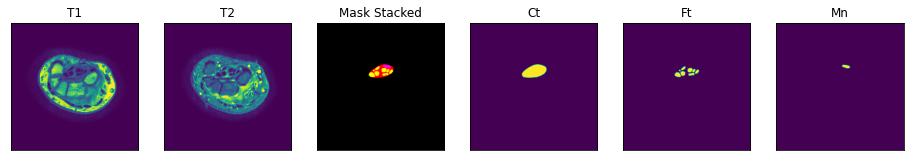

In [16]:
# visual data
visualize(
    t1=image[...,0],
    t2=image[...,1],
    mask_stacked=mask,
    ct=mask[...,0],
    ft=mask[...,1],
    mn=mask[...,2]
)

# preprocess & data augmentation

In [17]:
import albumentations as albu

def get_training_augmentation():
    # TODO: keep augmentation suitable for medical image
    train_transform = [

      albu.HorizontalFlip(p=0.5),

      albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

      albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
      albu.RandomCrop(height=320, width=320, always_apply=True),

      albu.IAAAdditiveGaussianNoise(p=0.2),
      albu.IAAPerspective(p=0.5),

      albu.OneOf(
          [
              albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
          ],
          p=0.9,
      ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_preprocessing_no_pretrain():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [19]:
#### Visualize augmented images and masks

augmented_trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_trainset[2]
    # visual data
    visualize(
        t1=image[...,0],
        t2=image[...,1],
        mask_stacked=mask,
        ct=mask[...,0],
        ft=mask[...,1],
        mn=mask[...,2]
    )

ValueError: ignored

# create model

In [20]:
# Download segmentation model pytorch
!pip install segmentation-models-pytorch

     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 245kB 23.9MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=3fc14bda2c6abead89213e95a3c77d5553fa025dd35e9e4547eea72ba4e00173
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=b2aa8f55cb8bb29ce089461e3c04fee49a02d03ab96c267465c23834ca0c3129
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


U-Net++

docs:
https://smp.readthedocs.io/en/latest/models.html#id2

```
segmentation_models_pytorch.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation=None, aux_params=None)
```



In [21]:
import segmentation_models_pytorch as smp
import torch

DEVICE = 'cpu'
if torch.cuda.is_available():
  print('using gpu')
  DEVICE = 'cuda'
else:
  print('using cpu')

# our input:
# t1, t2 stacked
# our output has 3 classes (ct, ft, mn)
# because our mask has overlay, so we should not use softmax at last layer activation
model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')

using gpu


In [33]:
!pip install torchsummary

In [34]:
from torchsummary import summary

if torch.cuda.is_available():
  summary(model.cuda(), (2, 576, 576))
else:
  summary(model, (2, 576, 576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 288]           6,272
       BatchNorm2d-2         [-1, 64, 288, 288]             128
              ReLU-3         [-1, 64, 288, 288]               0
         MaxPool2d-4         [-1, 64, 144, 144]               0
            Conv2d-5         [-1, 64, 144, 144]          36,864
       BatchNorm2d-6         [-1, 64, 144, 144]             128
              ReLU-7         [-1, 64, 144, 144]               0
            Conv2d-8         [-1, 64, 144, 144]          36,864
       BatchNorm2d-9         [-1, 64, 144, 144]             128
             ReLU-10         [-1, 64, 144, 144]               0
       BasicBlock-11         [-1, 64, 144, 144]               0
           Conv2d-12         [-1, 64, 144, 144]          36,864
      BatchNorm2d-13         [-1, 64, 144, 144]             128
             ReLU-14         [-1, 64, 1

# 5 fold cross-validation is required

In [ ]:
trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing_no_pretrain(),
)

In [ ]:
def trainLoaders(*datasets, batch_size=32):
  loaders = []
  for i in datasets:
    loaders.append(torch.utils.data.DataLoader(i, batch_size=batch_size, shuffle=True, num_workers=12))
  
  return loaders

In [ ]:
#split the training dataset into 5 fold
len_trainset_1_4 = len(trainset)//5
# the last fold
len_trainset_5 = len(trainset)%len_trainset_1_4 + len_trainset_1_4

training_sets = torch.utils.data.random_split(trainset, [len_trainset_1_4,len_trainset_1_4,len_trainset_1_4,len_trainset_1_4,len_trainset_5])
training_loaders = trainLoaders(*training_sets)

In [ ]:
training_loaders

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
save_model_path = '/content/gdrive/My Drive/ip_final'

# Dice loss and Dice Score

https://zhuanlan.zhihu.com/p/86704421

## dice loss = 1 - dice score

In [ ]:
five_fold_dice = {
    0: [], 1: [], 2: [], 3: [], 4: []
}

EPOCH = 100


In [ ]:
!nvidia-smi

Thu Dec 17 02:59:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |   3423MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#5-fold validation
#let the k-th trainloader be the validation
for k in range(5):
  print('\nfold #{} as valid'.format(k))
  for n_fold in range(5):
    print('\ntrain fold #{}'.format(n_fold))
    #do not train the validation data
    if(n_fold == k):
      print('fold #{} is validation, skip'.format(n_fold))
      continue
    
     # train model for N epochs
    max_score = 0

    for i in range(EPOCH):
        
        print('\nEpoch: {}'.format(i))

        train_logs = train_epoch.run(training_loaders[n_fold])
        valid_logs = valid_epoch.run(training_loaders[k])

        # save dice of each fold
        five_fold_dice[n_fold].append(1 - valid_logs['dice_loss'])

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['dice_loss']:
            max_score = valid_logs['dice_loss']
            torch.save(model.state_dict(), save_model_path + '/fold{}_best_model.pth'.format(n_fold))
            print('Model saved!')
            
        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')

串流輸出內容已截斷至最後 5000 行。

Epoch: 75
valid: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, dice_loss - 0.8036, iou_score - 0.4256]

Epoch: 76
valid: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, dice_loss - 0.7964, iou_score - 0.4387]

Epoch: 77
valid: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, dice_loss - 0.8096, iou_score - 0.4475]

Epoch: 78
valid: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, dice_loss - 0.8058, iou_score - 0.4234]

Epoch: 79
valid: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, dice_loss - 0.8167, iou_score - 0.4276]

Epoch: 80
valid: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, dice_loss - 0.802, iou_score - 0.4341]

Epoch: 81
valid: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, dice_loss - 0.8029, iou_score - 0.4448]

Epoch: 82
valid: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, dice_loss - 0.7928, iou_score - 0.46]

Epoch: 83
valid: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, dice_loss - 0.7978, iou_score - 0.4425]

Epoch: 84
valid: 100%|██████████| 2/2 [00:02<

## 5 fold dice score

In [ ]:
five_fold_dice

{0: [0.12107282876968384,
  0.13234975934028625,
  0.16266125440597534,
  0.14404726028442383,
  0.14228230714797974,
  0.14116734266281128,
  0.11322268843650818,
  0.12712690234184265,
  0.1391759216785431,
  0.13488680124282837,
  0.15999683737754822,
  0.12434622645378113,
  0.1522553563117981,
  0.12721842527389526,
  0.1577334702014923,
  0.14476755261421204,
  0.12073266506195068,
  0.15119850635528564,
  0.14594733715057373,
  0.12272435426712036,
  0.13524553179740906,
  0.11890038847923279,
  0.13185849785804749,
  0.14749589562416077,
  0.1381700336933136,
  0.1350502073764801,
  0.14413350820541382,
  0.13055145740509033,
  0.1464250087738037,
  0.15858709812164307,
  0.13438886404037476,
  0.1443360447883606,
  0.12762585282325745,
  0.15114262700080872,
  0.10386654734611511,
  0.16243994235992432,
  0.14578121900558472,
  0.1326502561569214,
  0.1521652340888977,
  0.15827012062072754,
  0.1261187195777893,
  0.15578129887580872,
  0.11536845564842224,
  0.13607940077781

## dice score when training

In [43]:
dice = {0: [0.12107282876968384,
  0.13234975934028625,
  0.16266125440597534,
  0.14404726028442383,
  0.14228230714797974,
  0.14116734266281128,
  0.11322268843650818,
  0.12712690234184265,
  0.1391759216785431,
  0.13488680124282837,
  0.15999683737754822,
  0.12434622645378113,
  0.1522553563117981,
  0.12721842527389526,
  0.1577334702014923,
  0.14476755261421204,
  0.12073266506195068,
  0.15119850635528564,
  0.14594733715057373,
  0.12272435426712036,
  0.13524553179740906,
  0.11890038847923279,
  0.13185849785804749,
  0.14749589562416077,
  0.1381700336933136,
  0.1350502073764801,
  0.14413350820541382,
  0.13055145740509033,
  0.1464250087738037,
  0.15858709812164307,
  0.13438886404037476,
  0.1443360447883606,
  0.12762585282325745,
  0.15114262700080872,
  0.10386654734611511,
  0.16243994235992432,
  0.14578121900558472,
  0.1326502561569214,
  0.1521652340888977,
  0.15827012062072754,
  0.1261187195777893,
  0.15578129887580872,
  0.11536845564842224,
  0.13607940077781677,
  0.13026180863380432,
  0.14376184344291687,
  0.12331768870353699,
  0.15567731857299805,
  0.1361943483352661,
  0.1632729470729828,
  0.1606719195842743,
  0.1377551257610321,
  0.1276131570339203,
  0.16260123252868652,
  0.16616502404212952,
  0.1367272138595581,
  0.12273526191711426,
  0.14999064803123474,
  0.1272314190864563,
  0.17050552368164062,
  0.17161571979522705,
  0.18657854199409485,
  0.1568198800086975,
  0.18364953994750977,
  0.1594049632549286,
  0.16429731249809265,
  0.12783268094062805,
  0.16783612966537476,
  0.16152361035346985,
  0.18011701107025146,
  0.1461891233921051,
  0.12752467393875122,
  0.14035221934318542,
  0.160475492477417,
  0.15704548358917236,
  0.1469094157218933,
  0.14125919342041016,
  0.14422479271888733,
  0.15826290845870972,
  0.15709367394447327,
  0.1389128565788269,
  0.16901180148124695,
  0.13184314966201782,
  0.13442137837409973,
  0.1412849724292755,
  0.17469725012779236,
  0.14862975478172302,
  0.1731441617012024,
  0.16272887587547302,
  0.15467926859855652,
  0.14081451296806335,
  0.15673178434371948,
  0.1675562858581543,
  0.1765877604484558,
  0.1587882936000824,
  0.15325096249580383,
  0.14003834128379822,
  0.14100584387779236,
  0.13437628746032715,
  0.173553466796875,
  0.17141193151474,
  0.14175477623939514,
  0.18713974952697754,
  0.1656421422958374,
  0.1559697687625885,
  0.1819092333316803,
  0.206557035446167,
  0.14594751596450806,
  0.20130854845046997,
  0.19271200895309448,
  0.19044950604438782,
  0.1877070665359497,
  0.178641676902771,
  0.19877725839614868,
  0.15717941522598267,
  0.22950416803359985,
  0.17477336525917053,
  0.21103042364120483,
  0.20256823301315308,
  0.18185406923294067,
  0.21686887741088867,
  0.2360905408859253,
  0.1801157295703888,
  0.18611496686935425,
  0.21886318922042847,
  0.17402216792106628,
  0.1978127658367157,
  0.1920624077320099,
  0.1996542513370514,
  0.18158739805221558,
  0.2027871012687683,
  0.15199095010757446,
  0.19193336367607117,
  0.17098519206047058,
  0.1450168788433075,
  0.2184845507144928,
  0.20111051201820374,
  0.20227190852165222,
  0.1803140640258789,
  0.20717853307724,
  0.18942004442214966,
  0.17040911316871643,
  0.18152368068695068,
  0.1941894292831421,
  0.17464569211006165,
  0.18756762146949768,
  0.22397300601005554,
  0.19812116026878357,
  0.20008403062820435,
  0.21302175521850586,
  0.17048615217208862,
  0.1932855248451233,
  0.17117524147033691,
  0.22112587094306946,
  0.2028452754020691,
  0.18752577900886536,
  0.22423407435417175,
  0.19030535221099854,
  0.18537473678588867,
  0.19884875416755676,
  0.20223873853683472,
  0.1997794508934021,
  0.20222902297973633,
  0.20051255822181702,
  0.15483766794204712,
  0.16618192195892334,
  0.19230109453201294,
  0.20502468943595886,
  0.21384751796722412,
  0.178542822599411,
  0.20843106508255005,
  0.19115683436393738,
  0.22132793068885803,
  0.21183520555496216,
  0.19835761189460754,
  0.20275470614433289,
  0.19197097420692444,
  0.22500330209732056,
  0.22689205408096313,
  0.18109795451164246,
  0.1979338824748993,
  0.22089621424674988,
  0.19919353723526,
  0.1805846393108368,
  0.1742120087146759,
  0.1849527657032013,
  0.20838478207588196,
  0.1727064847946167,
  0.18894752860069275,
  0.21856838464736938,
  0.1634427309036255,
  0.16034281253814697,
  0.19467347860336304,
  0.17468085885047913,
  0.20852255821228027,
  0.18925535678863525,
  0.1728091537952423,
  0.19905099272727966,
  0.1816929280757904,
  0.21315014362335205,
  0.22693130373954773,
  0.2109447717666626,
  0.21775996685028076,
  0.23096728324890137,
  0.2808276414871216,
  0.2436676025390625,
  0.253789484500885,
  0.2724531292915344,
  0.22051399946212769,
  0.29689615964889526,
  0.2612238824367523,
  0.23922526836395264,
  0.2652002274990082,
  0.2371339499950409,
  0.2864229679107666,
  0.20349907875061035,
  0.24293091893196106,
  0.2076593041419983,
  0.20628678798675537,
  0.2626667618751526,
  0.2521583139896393,
  0.2854466438293457,
  0.29234087467193604,
  0.2390516698360443,
  0.21282494068145752,
  0.24618911743164062,
  0.25515344738960266,
  0.23122408986091614,
  0.26453274488449097,
  0.28151965141296387,
  0.23826390504837036,
  0.23922088742256165,
  0.2773952782154083,
  0.29389435052871704,
  0.2754874527454376,
  0.2773630619049072,
  0.2735670208930969,
  0.2571268081665039,
  0.24857103824615479,
  0.2803459167480469,
  0.22290360927581787,
  0.24354779720306396,
  0.23145711421966553,
  0.24916526675224304,
  0.26152923703193665,
  0.3117516040802002,
  0.24883830547332764,
  0.260217547416687,
  0.2219288945198059,
  0.29650312662124634,
  0.2538965940475464,
  0.26527222990989685,
  0.27018502354621887,
  0.2797977030277252,
  0.2724874019622803,
  0.24410706758499146,
  0.29506853222846985,
  0.2752804160118103,
  0.2803512215614319,
  0.29896870255470276,
  0.2368813157081604,
  0.29841148853302,
  0.21399188041687012,
  0.2747753858566284,
  0.3110753893852234,
  0.26069268584251404,
  0.261793851852417,
  0.28062617778778076,
  0.27913445234298706,
  0.2978702187538147,
  0.2922164797782898,
  0.26282498240470886,
  0.2783752679824829,
  0.25582075119018555,
  0.27281665802001953,
  0.30661246180534363,
  0.3130132555961609,
  0.301329106092453,
  0.2719477415084839,
  0.31486496329307556,
  0.2842085063457489,
  0.278427392244339,
  0.25235235691070557,
  0.30206120014190674,
  0.2799348831176758,
  0.28059202432632446,
  0.28973090648651123,
  0.27303457260131836,
  0.27839428186416626,
  0.2559846341609955,
  0.2849328815937042,
  0.29195842146873474,
  0.2998114824295044,
  0.28723353147506714,
  0.25213155150413513,
  0.298542320728302,
  0.301916241645813,
  0.24947938323020935,
  0.3137151300907135,
  0.29256224632263184,
  0.3974698781967163,
  0.3897605538368225,
  0.35894590616226196,
  0.36220529675483704,
  0.3617390990257263,
  0.37815624475479126,
  0.394065260887146,
  0.34426483511924744,
  0.35743677616119385,
  0.38993027806282043,
  0.3905351161956787,
  0.351707398891449,
  0.37699154019355774,
  0.40231984853744507,
  0.41087591648101807,
  0.3616892993450165,
  0.3579365015029907,
  0.37199997901916504,
  0.3847314715385437,
  0.3543638288974762,
  0.3514876365661621,
  0.37955164909362793,
  0.3558904528617859,
  0.394691526889801,
  0.3485124111175537,
  0.3662235140800476,
  0.3799660801887512,
  0.38301822543144226,
  0.36596620082855225,
  0.3530198633670807,
  0.343841552734375,
  0.38253647089004517,
  0.3712059259414673,
  0.39669737219810486,
  0.3684404194355011,
  0.3491882085800171,
  0.3489137887954712,
  0.419158399105072,
  0.3359338045120239,
  0.36867526173591614,
  0.39642804861068726,
  0.36044520139694214,
  0.40892642736434937,
  0.34946340322494507,
  0.3584098219871521,
  0.33788439631462097,
  0.3883798122406006,
  0.3802720308303833,
  0.3816060423851013,
  0.39860090613365173,
  0.41429856419563293,
  0.39822322130203247,
  0.4007520377635956,
  0.36170104146003723,
  0.3502935767173767,
  0.36628639698028564,
  0.35995396971702576,
  0.386744886636734,
  0.41792991757392883,
  0.3914896845817566,
  0.3856660723686218,
  0.40607723593711853,
  0.35832417011260986,
  0.41503989696502686,
  0.39103004336357117,
  0.3537136912345886,
  0.38461270928382874,
  0.3896237909793854,
  0.3853737711906433,
  0.36519482731819153,
  0.3993435204029083,
  0.35492879152297974,
  0.3777351677417755,
  0.39425110816955566,
  0.3904988169670105,
  0.3647328317165375,
  0.3843895196914673,
  0.40103620290756226,
  0.4083055853843689,
  0.39089736342430115,
  0.38350802659988403,
  0.38261207938194275,
  0.3736420273780823,
  0.4265117049217224,
  0.3839077055454254,
  0.42128080129623413,
  0.457387238740921,
  0.3731895089149475,
  0.37435686588287354,
  0.3909943699836731,
  0.40717557072639465,
  0.37633103132247925,
  0.44133472442626953,
  0.42655009031295776,
  0.3804519474506378,
  0.376999169588089,
  0.4046391248703003,
  0.41812410950660706,
  0.3733448088169098,
  0.4078730344772339],
 1: [0.04731586575508118,
  0.04841777682304382,
  0.06146794557571411,
  0.03770768642425537,
  0.05017229914665222,
  0.05088654160499573,
  0.051179856061935425,
  0.04786652326583862,
  0.05077359080314636,
  0.05635976791381836,
  0.06730130314826965,
  0.09466820955276489,
  0.095662921667099,
  0.04145583510398865,
  0.08423611521720886,
  0.09049516916275024,
  0.07088616490364075,
  0.07475018501281738,
  0.08652907609939575,
  0.07222563028335571,
  0.09671586751937866,
  0.0946100652217865,
  0.10900875926017761,
  0.07941767573356628,
  0.10305929183959961,
  0.09221655130386353,
  0.0884895920753479,
  0.08580288290977478,
  0.10017082095146179,
  0.10590860247612,
  0.08404949307441711,
  0.10008278489112854,
  0.08714678883552551,
  0.10303571820259094,
  0.11420652270317078,
  0.10118508338928223,
  0.09442323446273804,
  0.08978497982025146,
  0.1002187430858612,
  0.08585929870605469,
  0.11413612961769104,
  0.07669004797935486,
  0.10575145483016968,
  0.08685404062271118,
  0.09907755255699158,
  0.08139005303382874,
  0.10941332578659058,
  0.1186293363571167,
  0.10592201352119446,
  0.08559015393257141,
  0.11362320184707642,
  0.0979626476764679,
  0.10950091481208801,
  0.10929828882217407,
  0.08187106251716614,
  0.12056735157966614,
  0.11665365099906921,
  0.11601030826568604,
  0.11918863654136658,
  0.10480040311813354,
  0.10046860575675964,
  0.11833861470222473,
  0.10154938697814941,
  0.09362867474555969,
  0.12353169918060303,
  0.13076022267341614,
  0.11333763599395752,
  0.10763141512870789,
  0.10068169236183167,
  0.10220369696617126,
  0.11636227369308472,
  0.08118835091590881,
  0.11403152346611023,
  0.12152761220932007,
  0.10535693168640137,
  0.12376746535301208,
  0.10049670934677124,
  0.1051616370677948,
  0.08509555459022522,
  0.11278530955314636,
  0.1123918890953064,
  0.11651194095611572,
  0.09142974019050598,
  0.08950510621070862,
  0.12863808870315552,
  0.12071079015731812,
  0.08575287461280823,
  0.08753195405006409,
  0.10946348309516907,
  0.10253563523292542,
  0.12727084755897522,
  0.09077829122543335,
  0.1281176209449768,
  0.11056584119796753,
  0.12168720364570618,
  0.11456131935119629,
  0.1069205105304718,
  0.12463343143463135,
  0.11818689107894897,
  0.1119239330291748,
  0.18187126517295837,
  0.21359461545944214,
  0.18977200984954834,
  0.20496585965156555,
  0.1541522741317749,
  0.22986868023872375,
  0.1803266704082489,
  0.18810194730758667,
  0.20772233605384827,
  0.23705491423606873,
  0.214793860912323,
  0.26088210940361023,
  0.19272243976593018,
  0.198438823223114,
  0.16584977507591248,
  0.2119821012020111,
  0.20794662833213806,
  0.1569591462612152,
  0.19180530309677124,
  0.20406672358512878,
  0.22429487109184265,
  0.21883326768875122,
  0.2127789855003357,
  0.22966960072517395,
  0.20254164934158325,
  0.19726595282554626,
  0.1901766061782837,
  0.223158597946167,
  0.17103329300880432,
  0.18198883533477783,
  0.18572327494621277,
  0.21580827236175537,
  0.1848519742488861,
  0.2258937954902649,
  0.23295298218727112,
  0.17748892307281494,
  0.17863163352012634,
  0.19131773710250854,
  0.1988014578819275,
  0.2133045792579651,
  0.21124395728111267,
  0.2000395655632019,
  0.1763751208782196,
  0.20144090056419373,
  0.17538970708847046,
  0.19729551672935486,
  0.18422812223434448,
  0.19522830843925476,
  0.20320719480514526,
  0.20742961764335632,
  0.2127419412136078,
  0.2249355912208557,
  0.1770000457763672,
  0.23615241050720215,
  0.19318798184394836,
  0.19737067818641663,
  0.16470631957054138,
  0.17661374807357788,
  0.1906621754169464,
  0.19711685180664062,
  0.2228659689426422,
  0.19087886810302734,
  0.20009106397628784,
  0.21598055958747864,
  0.23834797739982605,
  0.23785269260406494,
  0.20248249173164368,
  0.17825686931610107,
  0.2146584689617157,
  0.22146058082580566,
  0.19957318902015686,
  0.2178364098072052,
  0.214790940284729,
  0.20951077342033386,
  0.23768991231918335,
  0.20998495817184448,
  0.20205369591712952,
  0.21585088968276978,
  0.2162693440914154,
  0.20015671849250793,
  0.22093337774276733,
  0.20762288570404053,
  0.2284199297428131,
  0.22962141036987305,
  0.21809729933738708,
  0.17324459552764893,
  0.1400085985660553,
  0.2164413034915924,
  0.2232372760772705,
  0.22744736075401306,
  0.2057216465473175,
  0.26264092326164246,
  0.2305036187171936,
  0.18662557005882263,
  0.24549564719200134,
  0.2027917504310608,
  0.21461433172225952,
  0.2514150142669678,
  0.23435503244400024,
  0.21947941184043884,
  0.22879579663276672,
  0.31709516048431396,
  0.2980843186378479,
  0.26523083448410034,
  0.2680869400501251,
  0.2672228217124939,
  0.2620510458946228,
  0.2246977686882019,
  0.2929803133010864,
  0.2981751561164856,
  0.32178595662117004,
  0.30646392703056335,
  0.30241459608078003,
  0.348650723695755,
  0.2763705551624298,
  0.28662994503974915,
  0.2969885468482971,
  0.29918068647384644,
  0.2698539197444916,
  0.2685481607913971,
  0.2547908425331116,
  0.28379908204078674,
  0.2712923586368561,
  0.3481605648994446,
  0.2658091187477112,
  0.2636941969394684,
  0.2731701135635376,
  0.3174642026424408,
  0.24601426720619202,
  0.28188401460647583,
  0.2564235031604767,
  0.30817294120788574,
  0.27009761333465576,
  0.23454955220222473,
  0.32997435331344604,
  0.3095899820327759,
  0.28480064868927,
  0.29649797081947327,
  0.3193433880805969,
  0.31382670998573303,
  0.27744948863983154,
  0.28101399540901184,
  0.32461756467819214,
  0.2790176272392273,
  0.2955686151981354,
  0.29781532287597656,
  0.3262752592563629,
  0.29062914848327637,
  0.25493064522743225,
  0.30979469418525696,
  0.2782541513442993,
  0.3059955835342407,
  0.2620481848716736,
  0.3060983419418335,
  0.23802289366722107,
  0.29796767234802246,
  0.2664972245693207,
  0.3124428689479828,
  0.31051304936408997,
  0.29881227016448975,
  0.2785572111606598,
  0.29572829604148865,
  0.3188033699989319,
  0.29412126541137695,
  0.2707430124282837,
  0.27072492241859436,
  0.2989690899848938,
  0.3143717348575592,
  0.3078286647796631,
  0.2783271372318268,
  0.28359493613243103,
  0.2981438934803009,
  0.32702818512916565,
  0.29159051179885864,
  0.28400954604148865,
  0.3469177782535553,
  0.32923436164855957,
  0.3560968041419983,
  0.3196261525154114,
  0.30825522541999817,
  0.2677360773086548,
  0.2939375936985016,
  0.3100343346595764,
  0.2732056677341461,
  0.30531537532806396,
  0.2695946991443634,
  0.2955198287963867,
  0.19871005415916443,
  0.3287019729614258,
  0.31702154874801636,
  0.3096292018890381,
  0.31921854615211487,
  0.2902921736240387,
  0.2947309911251068,
  0.3243562877178192,
  0.32634010910987854,
  0.29557177424430847,
  0.33884677290916443,
  0.33016082644462585,
  0.28932511806488037,
  0.41947394609451294,
  0.38371187448501587,
  0.351598858833313,
  0.38235366344451904,
  0.3683857321739197,
  0.40722164511680603,
  0.4453267455101013,
  0.43427175283432007,
  0.4334336519241333,
  0.4116595685482025,
  0.44409096240997314,
  0.34860360622406006,
  0.409640908241272,
  0.41133201122283936,
  0.41620880365371704,
  0.4067334830760956,
  0.3931533396244049,
  0.36907675862312317,
  0.4183732271194458,
  0.4164320230484009,
  0.3664660155773163,
  0.44120457768440247,
  0.41265398263931274,
  0.4547480344772339,
  0.4047657251358032,
  0.39772945642471313,
  0.42599204182624817,
  0.3885106146335602,
  0.40019091963768005,
  0.437804251909256,
  0.38257673382759094,
  0.35261285305023193,
  0.3778373897075653,
  0.3811124563217163,
  0.39271098375320435,
  0.422884464263916,
  0.430867999792099,
  0.4092312455177307,
  0.43955957889556885,
  0.39759108424186707,
  0.4186146855354309,
  0.44757798314094543,
  0.4127568006515503,
  0.4217339754104614,
  0.3984110653400421,
  0.3928821086883545,
  0.37674325704574585,
  0.3932934105396271,
  0.4328833818435669,
  0.3832329511642456,
  0.4023534953594208,
  0.41125035285949707,
  0.37706664204597473,
  0.4320775866508484,
  0.41636013984680176,
  0.4256210923194885,
  0.4181801974773407,
  0.42262405157089233,
  0.40678295493125916,
  0.43046194314956665,
  0.3842378556728363,
  0.4273456931114197,
  0.39645829796791077,
  0.41466760635375977,
  0.4430553615093231,
  0.4450313448905945,
  0.4478815197944641,
  0.4325498938560486,
  0.4294363558292389,
  0.43268096446990967,
  0.4143516719341278,
  0.44621792435646057,
  0.43802955746650696,
  0.4269047677516937,
  0.4489825963973999,
  0.4357450604438782,
  0.38841843605041504,
  0.3962646424770355,
  0.3714076280593872,
  0.43019309639930725,
  0.413953572511673,
  0.4274069666862488,
  0.4435850977897644,
  0.4707075357437134,
  0.43291720747947693,
  0.3968854546546936,
  0.4265841841697693,
  0.4011691212654114,
  0.40459272265434265,
  0.3897920846939087,
  0.42361098527908325,
  0.44273895025253296,
  0.4190044105052948,
  0.3806648850440979,
  0.39983153343200684,
  0.44902652502059937,
  0.4096207320690155,
  0.4539240002632141,
  0.4592359662055969,
  0.4859738349914551],
 2: [0.1140369176864624,
  0.12240433692932129,
  0.11967259645462036,
  0.08811110258102417,
  0.10923632979393005,
  0.1156991720199585,
  0.10184931755065918,
  0.09364005923271179,
  0.13644763827323914,
  0.1135081946849823,
  0.13705694675445557,
  0.10738736391067505,
  0.11751580238342285,
  0.1040349006652832,
  0.10727670788764954,
  0.0913960337638855,
  0.12539005279541016,
  0.10583218932151794,
  0.09755674004554749,
  0.1236213743686676,
  0.10034078359603882,
  0.13021957874298096,
  0.10059341788291931,
  0.11136159300804138,
  0.14085635542869568,
  0.12615329027175903,
  0.11107951402664185,
  0.11850321292877197,
  0.11016792058944702,
  0.10112354159355164,
  0.10386505722999573,
  0.10627678036689758,
  0.12969306111335754,
  0.1002112329006195,
  0.11216923594474792,
  0.11174306273460388,
  0.12622982263565063,
  0.11082637310028076,
  0.12156558036804199,
  0.13643547892570496,
  0.08498689532279968,
  0.11670228838920593,
  0.10170337557792664,
  0.07708469033241272,
  0.11811500787734985,
  0.13178682327270508,
  0.11801084876060486,
  0.11604049801826477,
  0.1034790575504303,
  0.10955929756164551,
  0.10574084520339966,
  0.0999734103679657,
  0.11283421516418457,
  0.11403188109397888,
  0.11355054378509521,
  0.1084582507610321,
  0.12459421157836914,
  0.10316938161849976,
  0.1323062777519226,
  0.12014037370681763,
  0.11342200636863708,
  0.12453660368919373,
  0.12565603852272034,
  0.1305364966392517,
  0.12751725316047668,
  0.12776660919189453,
  0.145696222782135,
  0.15280959010124207,
  0.10113665461540222,
  0.12257540225982666,
  0.13212868571281433,
  0.13975203037261963,
  0.10473766922950745,
  0.11408495903015137,
  0.11124452948570251,
  0.13083374500274658,
  0.12586021423339844,
  0.08908623456954956,
  0.12026336789131165,
  0.1112525463104248,
  0.13453903794288635,
  0.11291974782943726,
  0.12639856338500977,
  0.11180895566940308,
  0.1049247682094574,
  0.11565187573432922,
  0.1260291337966919,
  0.15436890721321106,
  0.13514432311058044,
  0.1248510479927063,
  0.15550324320793152,
  0.11617451906204224,
  0.1346355378627777,
  0.11985954642295837,
  0.1286333203315735,
  0.13601553440093994,
  0.10187551379203796,
  0.11744576692581177,
  0.13703590631484985,
  0.11313372850418091,
  0.136604905128479,
  0.15270906686782837,
  0.1614980399608612,
  0.16171425580978394,
  0.14505720138549805,
  0.11847338080406189,
  0.12443646788597107,
  0.15805462002754211,
  0.17353606224060059,
  0.145595520734787,
  0.14263665676116943,
  0.1662919521331787,
  0.12491235136985779,
  0.15216001868247986,
  0.17972493171691895,
  0.15517854690551758,
  0.177573561668396,
  0.18494188785552979,
  0.15922194719314575,
  0.12464746832847595,
  0.14602237939834595,
  0.13886651396751404,
  0.11935737729072571,
  0.16061383485794067,
  0.13068437576293945,
  0.1763579547405243,
  0.1342354714870453,
  0.1650199294090271,
  0.15233862400054932,
  0.131517231464386,
  0.1754167377948761,
  0.18084749579429626,
  0.16501206159591675,
  0.17651396989822388,
  0.13916826248168945,
  0.1686493456363678,
  0.16887640953063965,
  0.13440126180648804,
  0.16452428698539734,
  0.16615870594978333,
  0.18007773160934448,
  0.1422213912010193,
  0.2113511562347412,
  0.13217878341674805,
  0.14812994003295898,
  0.14003589749336243,
  0.17283764481544495,
  0.1504003405570984,
  0.16952350735664368,
  0.1541828215122223,
  0.17297959327697754,
  0.16778236627578735,
  0.18403911590576172,
  0.1770918071269989,
  0.15257561206817627,
  0.15296483039855957,
  0.13351643085479736,
  0.15004047751426697,
  0.18483787775039673,
  0.120616614818573,
  0.1644584834575653,
  0.18340885639190674,
  0.14421546459197998,
  0.1627059280872345,
  0.1712634265422821,
  0.16899597644805908,
  0.1724231243133545,
  0.14402034878730774,
  0.16833144426345825,
  0.19209611415863037,
  0.17232927680015564,
  0.1809871792793274,
  0.1970788836479187,
  0.17233890295028687,
  0.14998051524162292,
  0.1600259244441986,
  0.17896577715873718,
  0.16894033551216125,
  0.14348071813583374,
  0.15629643201828003,
  0.18573367595672607,
  0.15732413530349731,
  0.16551253199577332,
  0.1306656301021576,
  0.16456177830696106,
  0.14349690079689026,
  0.15634280443191528,
  0.14877551794052124,
  0.14057660102844238,
  0.1626453697681427,
  0.17757874727249146,
  0.12698957324028015,
  0.17233043909072876,
  0.16072389483451843,
  0.170109361410141,
  0.11466452479362488,
  0.15485107898712158,
  0.16492235660552979,
  0.1395096480846405,
  0.15707656741142273,
  0.30702370405197144,
  0.32587289810180664,
  0.32663223147392273,
  0.3473317325115204,
  0.35512053966522217,
  0.28304794430732727,
  0.2751504182815552,
  0.29375767707824707,
  0.34710630774497986,
  0.33409976959228516,
  0.3399840295314789,
  0.3022180199623108,
  0.3203502595424652,
  0.33809593319892883,
  0.3205168843269348,
  0.3280584514141083,
  0.3353075683116913,
  0.2935524880886078,
  0.31192508339881897,
  0.28310245275497437,
  0.3441171646118164,
  0.30323243141174316,
  0.35948479175567627,
  0.33003926277160645,
  0.32340478897094727,
  0.31960198283195496,
  0.3082321882247925,
  0.30928629636764526,
  0.4005870223045349,
  0.36505550146102905,
  0.31604552268981934,
  0.2935909330844879,
  0.34680232405662537,
  0.2626257538795471,
  0.3625452518463135,
  0.30950862169265747,
  0.33532023429870605,
  0.2869935929775238,
  0.308530330657959,
  0.2731451392173767,
  0.3296625018119812,
  0.3012795150279999,
  0.34000083804130554,
  0.3384947180747986,
  0.3351295590400696,
  0.34316277503967285,
  0.3168269097805023,
  0.28058815002441406,
  0.26234710216522217,
  0.32378214597702026,
  0.34366166591644287,
  0.36259669065475464,
  0.35700127482414246,
  0.2651505768299103,
  0.30026310682296753,
  0.29246264696121216,
  0.3323465585708618,
  0.31116464734077454,
  0.30476632714271545,
  0.27445995807647705,
  0.32332783937454224,
  0.31917864084243774,
  0.3140890300273895,
  0.3405064344406128,
  0.30867117643356323,
  0.2704475224018097,
  0.3583390712738037,
  0.32872331142425537,
  0.3087703585624695,
  0.3065144121646881,
  0.32056665420532227,
  0.33426329493522644,
  0.33612167835235596,
  0.36072924733161926,
  0.3373035192489624,
  0.34729868173599243,
  0.3334895074367523,
  0.33426785469055176,
  0.3472476899623871,
  0.3269680142402649,
  0.3458516001701355,
  0.30536699295043945,
  0.2842097878456116,
  0.3348994255065918,
  0.3054904639720917,
  0.34271010756492615,
  0.28329169750213623,
  0.29480117559432983,
  0.28831902146339417,
  0.28975552320480347,
  0.3815770149230957,
  0.3135793209075928,
  0.3178602159023285,
  0.3746320903301239,
  0.33837541937828064,
  0.3597659170627594,
  0.3087121844291687,
  0.33762094378471375,
  0.3285887539386749,
  0.34045496582984924,
  0.45143258571624756,
  0.3864753544330597,
  0.4661202132701874,
  0.41650453209877014,
  0.42042526602745056,
  0.44834840297698975,
  0.4268534779548645,
  0.3918747007846832,
  0.4520045518875122,
  0.45691704750061035,
  0.4561302959918976,
  0.419244647026062,
  0.4405541718006134,
  0.43984079360961914,
  0.41260334849357605,
  0.4007461667060852,
  0.38636013865470886,
  0.44480305910110474,
  0.47467780113220215,
  0.4712216854095459,
  0.4547167718410492,
  0.465695321559906,
  0.4114227592945099,
  0.45408663153648376,
  0.4581547975540161,
  0.4360427260398865,
  0.47533345222473145,
  0.37731504440307617,
  0.3203590214252472,
  0.4376494586467743,
  0.438253253698349,
  0.42395785450935364,
  0.4434630572795868,
  0.4434358477592468,
  0.45856237411499023,
  0.3987627625465393,
  0.42775759100914,
  0.40877288579940796,
  0.4459975063800812,
  0.42183321714401245,
  0.4508128762245178,
  0.42382606863975525,
  0.43957674503326416,
  0.43054765462875366,
  0.46583986282348633,
  0.48092183470726013,
  0.42665424942970276,
  0.4610916078090668,
  0.48304352164268494,
  0.447092741727829,
  0.4597257375717163,
  0.45225921273231506,
  0.44852209091186523,
  0.44554299116134644,
  0.45208877325057983,
  0.40466076135635376,
  0.42354661226272583,
  0.43086862564086914,
  0.460207462310791,
  0.44314470887184143,
  0.4220702648162842,
  0.5099658966064453,
  0.5033147931098938,
  0.4729757308959961,
  0.45693787932395935,
  0.4580288529396057,
  0.46499043703079224,
  0.4641428291797638,
  0.4775609076023102,
  0.4538101553916931,
  0.4432406425476074,
  0.46293359994888306,
  0.4463315010070801,
  0.4726112484931946,
  0.4775121808052063,
  0.45987388491630554,
  0.46017006039619446,
  0.4909153878688812,
  0.4624064862728119,
  0.43755263090133667,
  0.45333635807037354,
  0.43576768040657043,
  0.40384554862976074,
  0.5043957829475403,
  0.44171690940856934,
  0.46965742111206055,
  0.49591580033302307,
  0.44173601269721985,
  0.4366244077682495,
  0.45739981532096863,
  0.4537808895111084,
  0.44421300292015076,
  0.4791962504386902,
  0.44358640909194946,
  0.46764129400253296,
  0.49078330397605896,
  0.5010587871074677,
  0.49459925293922424,
  0.4540126323699951,
  0.46856021881103516],
 3: [0.14423131942749023,
  0.13505509495735168,
  0.12752854824066162,
  0.1036960780620575,
  0.15472093224525452,
  0.11968448758125305,
  0.11480271816253662,
  0.13917893171310425,
  0.09753000736236572,
  0.10888153314590454,
  0.13033351302146912,
  0.1110016405582428,
  0.1280774176120758,
  0.12147444486618042,
  0.10131016373634338,
  0.09301972389221191,
  0.12873616814613342,
  0.11727511882781982,
  0.12172546982765198,
  0.09490793943405151,
  0.13651293516159058,
  0.11612415313720703,
  0.13036209344863892,
  0.11112207174301147,
  0.10818400979042053,
  0.13321253657341003,
  0.10199606418609619,
  0.14609161019325256,
  0.14366307854652405,
  0.10816633701324463,
  0.1186089813709259,
  0.11605653166770935,
  0.1356002688407898,
  0.13970217108726501,
  0.11257383227348328,
  0.14740395545959473,
  0.11336389183998108,
  0.13151833415031433,
  0.11661490797996521,
  0.10386061668395996,
  0.13267561793327332,
  0.11831575632095337,
  0.124169260263443,
  0.10601234436035156,
  0.10066336393356323,
  0.13027805089950562,
  0.11315307021141052,
  0.11968037486076355,
  0.08273768424987793,
  0.13586875796318054,
  0.14672955870628357,
  0.14513784646987915,
  0.12239900231361389,
  0.1127985417842865,
  0.14690297842025757,
  0.12077447772026062,
  0.10965830087661743,
  0.14545157551765442,
  0.12252044677734375,
  0.13171091675758362,
  0.10504671931266785,
  0.12273946404457092,
  0.10906648635864258,
  0.12760114669799805,
  0.13915812969207764,
  0.11165502667427063,
  0.12110739946365356,
  0.10744574666023254,
  0.12966400384902954,
  0.10457780957221985,
  0.14178508520126343,
  0.12607502937316895,
  0.11611393094062805,
  0.11182931065559387,
  0.13737881183624268,
  0.13944098353385925,
  0.12060099840164185,
  0.14218169450759888,
  0.13808250427246094,
  0.11036065220832825,
  0.11376211047172546,
  0.15153437852859497,
  0.14245033264160156,
  0.11257344484329224,
  0.13546380400657654,
  0.130655437707901,
  0.1637919843196869,
  0.12350952625274658,
  0.09818291664123535,
  0.1310962438583374,
  0.12448367476463318,
  0.1460454761981964,
  0.12636488676071167,
  0.12524732947349548,
  0.13709884881973267,
  0.11140307784080505,
  0.11193937063217163,
  0.1440768539905548,
  0.12641704082489014,
  0.15126574039459229,
  0.16581201553344727,
  0.1527467668056488,
  0.1982991099357605,
  0.16022425889968872,
  0.11706706881523132,
  0.1306898295879364,
  0.17858043313026428,
  0.17729619145393372,
  0.18216001987457275,
  0.1790241301059723,
  0.15546473860740662,
  0.16193699836730957,
  0.20022013783454895,
  0.14862951636314392,
  0.1681308150291443,
  0.13141658902168274,
  0.17183324694633484,
  0.17737489938735962,
  0.1547544002532959,
  0.17088449001312256,
  0.1855846643447876,
  0.1655307412147522,
  0.19217237830162048,
  0.1302025020122528,
  0.15619534254074097,
  0.1692744493484497,
  0.16270604729652405,
  0.1534152328968048,
  0.1504932940006256,
  0.18478676676750183,
  0.13953492045402527,
  0.16585120558738708,
  0.16869387030601501,
  0.17536941170692444,
  0.1530211865901947,
  0.16995587944984436,
  0.17832154035568237,
  0.14697274565696716,
  0.18153351545333862,
  0.177901029586792,
  0.19042304158210754,
  0.1838255226612091,
  0.17629265785217285,
  0.18207469582557678,
  0.1630895435810089,
  0.16998761892318726,
  0.19298309087753296,
  0.2114700973033905,
  0.1542218029499054,
  0.16070744395256042,
  0.15079456567764282,
  0.1755416989326477,
  0.15147635340690613,
  0.15169253945350647,
  0.19527801871299744,
  0.17924150824546814,
  0.18538007140159607,
  0.1270160675048828,
  0.1353122889995575,
  0.16480472683906555,
  0.19437286257743835,
  0.19043734669685364,
  0.16328832507133484,
  0.18393850326538086,
  0.18113568425178528,
  0.16107165813446045,
  0.18342965841293335,
  0.13839176297187805,
  0.14885330200195312,
  0.16684988141059875,
  0.15234899520874023,
  0.16743603348731995,
  0.17401492595672607,
  0.15480384230613708,
  0.14591270685195923,
  0.152346670627594,
  0.16807648539543152,
  0.1696987748146057,
  0.1727754771709442,
  0.15196800231933594,
  0.16487613320350647,
  0.1747334599494934,
  0.1889679729938507,
  0.18395531177520752,
  0.21252262592315674,
  0.19433850049972534,
  0.1473778486251831,
  0.2235824167728424,
  0.168544739484787,
  0.16789236664772034,
  0.166437029838562,
  0.17316436767578125,
  0.16828247904777527,
  0.18749171495437622,
  0.16340523958206177,
  0.1666872799396515,
  0.18572595715522766,
  0.18613600730895996,
  0.1423850953578949,
  0.20007872581481934,
  0.20821845531463623,
  0.22073543071746826,
  0.18741697072982788,
  0.2365894317626953,
  0.20626011490821838,
  0.22752642631530762,
  0.2158171534538269,
  0.21769404411315918,
  0.22387096285820007,
  0.2222883105278015,
  0.21055123209953308,
  0.1987171769142151,
  0.22609847784042358,
  0.19666212797164917,
  0.2205665111541748,
  0.2436213493347168,
  0.2396964430809021,
  0.2153361737728119,
  0.229893296957016,
  0.24813947081565857,
  0.24338173866271973,
  0.1507529318332672,
  0.21013250946998596,
  0.2281568944454193,
  0.24934080243110657,
  0.25005921721458435,
  0.2326056957244873,
  0.2019651234149933,
  0.22219964861869812,
  0.20494213700294495,
  0.20525816082954407,
  0.22348839044570923,
  0.24860814213752747,
  0.21916157007217407,
  0.23256123065948486,
  0.24194347858428955,
  0.19172295928001404,
  0.23614078760147095,
  0.2457943558692932,
  0.2229071855545044,
  0.21277305483818054,
  0.23224225640296936,
  0.2514006197452545,
  0.2423967719078064,
  0.2112986445426941,
  0.23068395256996155,
  0.2365734875202179,
  0.2317359745502472,
  0.2393488585948944,
  0.22214564681053162,
  0.19721966981887817,
  0.16650351881980896,
  0.24387922883033752,
  0.21515622735023499,
  0.20897263288497925,
  0.23389917612075806,
  0.21182632446289062,
  0.19848871231079102,
  0.21676504611968994,
  0.22685155272483826,
  0.22028887271881104,
  0.25613901019096375,
  0.23157471418380737,
  0.24485403299331665,
  0.20848628878593445,
  0.27984169125556946,
  0.2591620087623596,
  0.22892984747886658,
  0.20800089836120605,
  0.23723331093788147,
  0.21062499284744263,
  0.23131421208381653,
  0.2321619689464569,
  0.2073160707950592,
  0.18858152627944946,
  0.21300458908081055,
  0.22799521684646606,
  0.24332544207572937,
  0.24609318375587463,
  0.20021125674247742,
  0.21104535460472107,
  0.21182149648666382,
  0.2335413098335266,
  0.18487364053726196,
  0.21829581260681152,
  0.25521883368492126,
  0.22589418292045593,
  0.21579736471176147,
  0.227873295545578,
  0.22845977544784546,
  0.28488561511039734,
  0.24399641156196594,
  0.21875518560409546,
  0.24257856607437134,
  0.21637862920761108,
  0.2543092966079712,
  0.19779366254806519,
  0.25350210070610046,
  0.21519798040390015,
  0.23407283425331116,
  0.4695545732975006,
  0.4420109987258911,
  0.46576109528541565,
  0.49188485741615295,
  0.4687630534172058,
  0.44967833161354065,
  0.4615325331687927,
  0.4655598998069763,
  0.47282809019088745,
  0.49747616052627563,
  0.47362035512924194,
  0.4624958634376526,
  0.4790573716163635,
  0.437485009431839,
  0.4928639829158783,
  0.4595877230167389,
  0.466891884803772,
  0.4285297393798828,
  0.4692946672439575,
  0.47834667563438416,
  0.4844646751880646,
  0.48858335614204407,
  0.4425264298915863,
  0.45954883098602295,
  0.47967100143432617,
  0.46800896525382996,
  0.4773387908935547,
  0.48705750703811646,
  0.4321708083152771,
  0.48274755477905273,
  0.46687614917755127,
  0.46524959802627563,
  0.46921175718307495,
  0.5054306387901306,
  0.47687938809394836,
  0.46351784467697144,
  0.47698453068733215,
  0.48179954290390015,
  0.4850417673587799,
  0.4917362630367279,
  0.46388137340545654,
  0.5131581723690033,
  0.5245026051998138,
  0.45959097146987915,
  0.5020567178726196,
  0.5146154463291168,
  0.4366413950920105,
  0.43008390069007874,
  0.4453970193862915,
  0.4880560338497162,
  0.48069459199905396,
  0.49701839685440063,
  0.4799818992614746,
  0.46807634830474854,
  0.45951563119888306,
  0.4688412547111511,
  0.46574974060058594,
  0.4782601594924927,
  0.4510805010795593,
  0.4913989305496216,
  0.5040510892868042,
  0.4351801872253418,
  0.49155375361442566,
  0.49958091974258423,
  0.5146911144256592,
  0.4792650640010834,
  0.47684869170188904,
  0.4470866322517395,
  0.46178391575813293,
  0.4418681263923645,
  0.44425058364868164,
  0.47111329436302185,
  0.4941285252571106,
  0.4632396996021271,
  0.5030759572982788,
  0.4631921648979187,
  0.4694277346134186,
  0.40838709473609924,
  0.5242775976657867,
  0.4870847165584564,
  0.4880417585372925,
  0.5028265118598938,
  0.5213558077812195,
  0.3978714346885681,
  0.5009625256061554,
  0.44115468859672546,
  0.4891061782836914,
  0.46911314129829407,
  0.4664611518383026,
  0.4981049597263336,
  0.5186151266098022,
  0.5342855453491211,
  0.43368303775787354,
  0.47689828276634216,
  0.49084651470184326,
  0.48010796308517456,
  0.45734903216362,
  0.5164629817008972,
  0.486669659614563,
  0.46718066930770874],
 4: [0.11331561207771301,
  0.14218685030937195,
  0.1289324164390564,
  0.1422484815120697,
  0.13503146171569824,
  0.14671462774276733,
  0.15611428022384644,
  0.1400637924671173,
  0.1092056930065155,
  0.14982739090919495,
  0.13891908526420593,
  0.13723278045654297,
  0.11738106608390808,
  0.14603638648986816,
  0.10938361287117004,
  0.12962958216667175,
  0.13429167866706848,
  0.12667840719223022,
  0.14408636093139648,
  0.1286085546016693,
  0.13690593838691711,
  0.14537030458450317,
  0.16213393211364746,
  0.11893531680107117,
  0.11509862542152405,
  0.12915539741516113,
  0.14585694670677185,
  0.11071711778640747,
  0.12238436937332153,
  0.12438172101974487,
  0.13605278730392456,
  0.1219087541103363,
  0.114164799451828,
  0.14749062061309814,
  0.12290880084037781,
  0.14220646023750305,
  0.13588932156562805,
  0.15533891320228577,
  0.13515785336494446,
  0.11027666926383972,
  0.11014994978904724,
  0.1339513659477234,
  0.15437623858451843,
  0.15483689308166504,
  0.13362336158752441,
  0.14910945296287537,
  0.12930381298065186,
  0.11891469359397888,
  0.14021286368370056,
  0.1260165274143219,
  0.11700251698493958,
  0.13836953043937683,
  0.12902945280075073,
  0.12745001912117004,
  0.1192237138748169,
  0.13477933406829834,
  0.09528616070747375,
  0.16771546006202698,
  0.14033421874046326,
  0.13360106945037842,
  0.11107400059700012,
  0.12818056344985962,
  0.14738428592681885,
  0.12992903590202332,
  0.13941174745559692,
  0.13262006640434265,
  0.13376009464263916,
  0.14589178562164307,
  0.13319987058639526,
  0.14768829941749573,
  0.13452968001365662,
  0.10554328560829163,
  0.12817782163619995,
  0.11702877283096313,
  0.1381533443927765,
  0.1380024254322052,
  0.12762120366096497,
  0.1320113241672516,
  0.12190622091293335,
  0.11200949549674988,
  0.10336250066757202,
  0.13174143433570862,
  0.15804779529571533,
  0.12720933556556702,
  0.13420528173446655,
  0.12715083360671997,
  0.10469269752502441,
  0.13614708185195923,
  0.1470596194267273,
  0.12730950117111206,
  0.13021576404571533,
  0.13101258873939514,
  0.11986404657363892,
  0.10033857822418213,
  0.14364176988601685,
  0.14688315987586975,
  0.12515848875045776,
  0.13139498233795166,
  0.123085618019104,
  0.1345718502998352,
  0.16968753933906555,
  0.1551213562488556,
  0.16771537065505981,
  0.16654279828071594,
  0.15681496262550354,
  0.19373926520347595,
  0.17859163880348206,
  0.18286842107772827,
  0.17045575380325317,
  0.17217203974723816,
  0.1971157193183899,
  0.1882091760635376,
  0.17647254467010498,
  0.17624786496162415,
  0.17294570803642273,
  0.16425806283950806,
  0.16188141703605652,
  0.14916899800300598,
  0.1480828821659088,
  0.18670281767845154,
  0.19483068585395813,
  0.19145119190216064,
  0.19014859199523926,
  0.17039167881011963,
  0.1562388837337494,
  0.1673702597618103,
  0.17534083127975464,
  0.145767480134964,
  0.15266960859298706,
  0.17644140124320984,
  0.16025155782699585,
  0.15105441212654114,
  0.18114396929740906,
  0.14694011211395264,
  0.18649005889892578,
  0.1636962592601776,
  0.1625518500804901,
  0.1597663164138794,
  0.21978768706321716,
  0.20050597190856934,
  0.17752861976623535,
  0.1984422504901886,
  0.16691681742668152,
  0.17014095187187195,
  0.17047888040542603,
  0.1652265191078186,
  0.1882544755935669,
  0.16776514053344727,
  0.19252994656562805,
  0.18761026859283447,
  0.17304131388664246,
  0.20396485924720764,
  0.17527663707733154,
  0.17165952920913696,
  0.18896684050559998,
  0.20820307731628418,
  0.1602473258972168,
  0.17012277245521545,
  0.1740800142288208,
  0.1751329004764557,
  0.13136863708496094,
  0.14628306031227112,
  0.17950409650802612,
  0.1825617253780365,
  0.18547993898391724,
  0.13536232709884644,
  0.1599605679512024,
  0.17868727445602417,
  0.17545807361602783,
  0.15333563089370728,
  0.17677271366119385,
  0.20058083534240723,
  0.15891435742378235,
  0.12055996060371399,
  0.20592501759529114,
  0.19636183977127075,
  0.20358088612556458,
  0.19040650129318237,
  0.1941906213760376,
  0.18326494097709656,
  0.19797804951667786,
  0.19714340567588806,
  0.2071886956691742,
  0.20217496156692505,
  0.17477130889892578,
  0.20578217506408691,
  0.18130049109458923,
  0.17873355746269226,
  0.1402437388896942,
  0.17549613118171692,
  0.21070921421051025,
  0.21518287062644958,
  0.18678018450737,
  0.21875408291816711,
  0.19244873523712158,
  0.20894849300384521,
  0.19050759077072144,
  0.1537812054157257,
  0.16712158918380737,
  0.20297771692276,
  0.2531859874725342,
  0.1861136257648468,
  0.24462011456489563,
  0.25451239943504333,
  0.26273560523986816,
  0.24419549107551575,
  0.2495860755443573,
  0.2690827250480652,
  0.26435425877571106,
  0.25153017044067383,
  0.22163322567939758,
  0.207662433385849,
  0.2422451376914978,
  0.2572527527809143,
  0.24489885568618774,
  0.24451303482055664,
  0.22393247485160828,
  0.22651004791259766,
  0.2864449620246887,
  0.25015807151794434,
  0.2989386320114136,
  0.24680069088935852,
  0.2532230615615845,
  0.24307826161384583,
  0.23116707801818848,
  0.22111204266548157,
  0.2755558490753174,
  0.27859339118003845,
  0.2400323748588562,
  0.29703134298324585,
  0.18512091040611267,
  0.2586052417755127,
  0.224527508020401,
  0.26084768772125244,
  0.21915990114212036,
  0.23362359404563904,
  0.22722649574279785,
  0.2299048900604248,
  0.2726486325263977,
  0.25923994183540344,
  0.22583264112472534,
  0.2713165879249573,
  0.23251888155937195,
  0.26314210891723633,
  0.20976528525352478,
  0.2029590904712677,
  0.27831071615219116,
  0.22386223077774048,
  0.2388937771320343,
  0.26586222648620605,
  0.24040380120277405,
  0.2664127051830292,
  0.24394655227661133,
  0.23119670152664185,
  0.232343852519989,
  0.2426990568637848,
  0.2659110724925995,
  0.24279659986495972,
  0.2325611114501953,
  0.21342551708221436,
  0.2503948211669922,
  0.2154572308063507,
  0.24994876980781555,
  0.22285720705986023,
  0.2543392777442932,
  0.20447123050689697,
  0.2775276303291321,
  0.24660226702690125,
  0.24936795234680176,
  0.22437793016433716,
  0.206952303647995,
  0.2534750998020172,
  0.2546907067298889,
  0.24494487047195435,
  0.24909904599189758,
  0.23393824696540833,
  0.2052823007106781,
  0.2250497043132782,
  0.2397354245185852,
  0.2788988947868347,
  0.25359535217285156,
  0.24065130949020386,
  0.21062389016151428,
  0.23508641123771667,
  0.2623533010482788,
  0.27505815029144287,
  0.2548936903476715,
  0.24678188562393188,
  0.26694783568382263,
  0.21415925025939941,
  0.26886457204818726,
  0.2790813744068146,
  0.23250257968902588,
  0.23039013147354126,
  0.26320433616638184,
  0.22774651646614075,
  0.25539687275886536,
  0.26752209663391113,
  0.2289963662624359,
  0.29560762643814087,
  0.3547196388244629,
  0.3393183648586273,
  0.3582835793495178,
  0.3762107491493225,
  0.31211376190185547,
  0.35446012020111084,
  0.339691162109375,
  0.32816872000694275,
  0.3078562617301941,
  0.3570898473262787,
  0.3153354525566101,
  0.36782926321029663,
  0.28404685854911804,
  0.31368961930274963,
  0.33063679933547974,
  0.382335364818573,
  0.2789216637611389,
  0.3474407196044922,
  0.3812340199947357,
  0.35320156812667847,
  0.3638744652271271,
  0.35674503445625305,
  0.4022817611694336,
  0.3931784927845001,
  0.3684181571006775,
  0.3863118886947632,
  0.34859639406204224,
  0.3696250319480896,
  0.3645347058773041,
  0.37788909673690796,
  0.3556824326515198,
  0.41322219371795654,
  0.35811805725097656,
  0.3312104642391205,
  0.3438987135887146,
  0.34858089685440063,
  0.3429400324821472,
  0.31336331367492676,
  0.37897807359695435,
  0.3683304786682129,
  0.3483312726020813,
  0.3716980814933777,
  0.39383894205093384,
  0.3411807417869568,
  0.3248521685600281,
  0.3756484389305115,
  0.34340181946754456,
  0.3150794506072998,
  0.3992152214050293,
  0.39783787727355957,
  0.3341904878616333,
  0.36997246742248535,
  0.4020244777202606,
  0.4121382534503937,
  0.3578760623931885,
  0.3962571620941162,
  0.3189474046230316,
  0.3735966086387634,
  0.4127112030982971,
  0.3448498547077179,
  0.33410197496414185,
  0.33466386795043945,
  0.3481561243534088,
  0.40775948762893677,
  0.3308289647102356,
  0.3797655999660492,
  0.3548066318035126,
  0.37361109256744385,
  0.373146116733551,
  0.3966842293739319,
  0.3683738708496094,
  0.35433921217918396,
  0.36125510931015015,
  0.37413641810417175,
  0.38113394379615784,
  0.3962380886077881,
  0.30632269382476807,
  0.3894023001194,
  0.3699869215488434,
  0.33584269881248474,
  0.3227870762348175,
  0.33151593804359436,
  0.3899480700492859,
  0.3382875323295593,
  0.3782089352607727,
  0.362091064453125,
  0.4027665853500366,
  0.4171755313873291,
  0.33549442887306213,
  0.38579118251800537,
  0.418474942445755,
  0.37064069509506226,
  0.41565021872520447,
  0.34987619519233704,
  0.4255715608596802,
  0.39962270855903625,
  0.3763846755027771,
  0.36809611320495605,
  0.4402095377445221,
  0.3978345990180969]}

## plot dice score

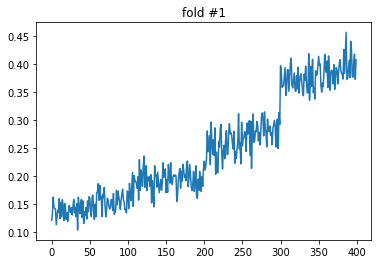

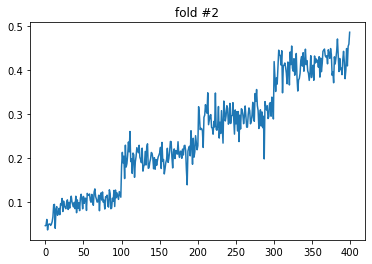

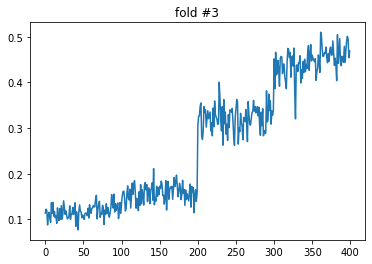

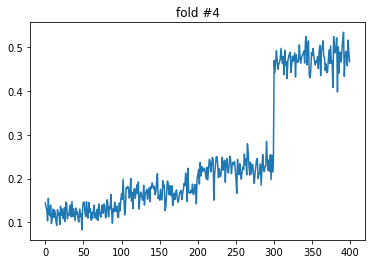

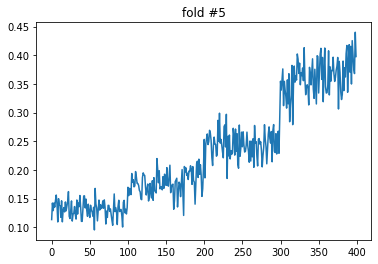

In [63]:
for i in range(5):
  plt.figure(i)
  plt.title('fold #{}'.format(i+1))
  plt.plot(dice[i])

## load trained model

In [32]:
DEVICE = 'cpu'
if torch.cuda.is_available():
  print('using gpu')
  DEVICE = "cuda:0"
else:
  print('using cpu')

using gpu


In [33]:
load_model_path = F"/content/gdrive/My Drive/ip_final/fold4_best_model.pth"

In [34]:
model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')
model.load_state_dict(torch.load(load_model_path, map_location=DEVICE))
if torch.cuda.is_available():
  model.cuda()

# see result

In [35]:
testset_path = F"/content/gdrive/My Drive/ip_final/data/test"

testset = Dataset(
    testset_path,
)

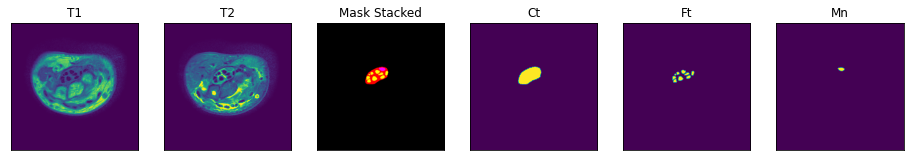

In [37]:
x, y = testset[1]

# visual input data and mask
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2]
)

## convert numpy to tensor

In [38]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

In [39]:
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)

# convert to tensor
image_tensor = transform(_x)

# take the first two images
image_tensor = image_tensor[0:2]

# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)

# cast to float
image_tensor = image_tensor.float()

image_tensor.shape

torch.Size([1, 2, 512, 512])

## fit model

In [42]:
model.eval()

if torch.cuda.is_available():
  image_tensor = image_tensor.cuda()

pred = model(image_tensor)

pred.shape

torch.Size([1, 3, 512, 512])

## convert tensor to numpy

In [43]:
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()

# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

np_pred.shape

(512, 512, 3)

## show the predicted result

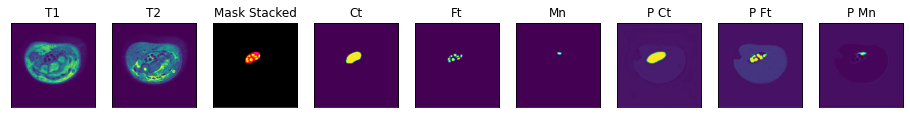

In [44]:
# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)

## evaluate
https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/metrics.py

In [45]:
import segmentation_models_pytorch.utils.metrics as metrics

In [48]:
# transfrom groundtruth to tensor
_y = transform(y)
_y = _y.unsqueeze(0)
if torch.cuda.is_available():
  _y = _y.cuda()

_y.shape

torch.Size([1, 3, 512, 512])

In [49]:
# IoU
metrics.IoU()(pred, _y)

tensor(0.7072, device='cuda:0', dtype=torch.float64)

In [50]:
# Dice Score
metrics.Fscore()(pred, _y)

tensor(0.8285, device='cuda:0', dtype=torch.float64)

## evaluate ct ft mn seperatly

In [51]:
# get each layer by
pred[:, 1, ...].shape

torch.Size([1, 512, 512])

In [52]:
print('ct iou')
print(metrics.IoU()(pred[:, 0, ...], _y[:, 0, ...]))
print('ct dice')
print(metrics.Fscore()(pred[:, 0, ...], _y[:, 0, ...]))
print('ft iou')
print(metrics.IoU()(pred[:, 1, ...], _y[:, 1, ...]))
print('ft dice')
print(metrics.Fscore()(pred[:, 1, ...], _y[:, 1, ...]))
print('mn iou')
print(metrics.IoU()(pred[:, 2, ...], _y[:, 2, ...]))
print('mn dice')
print(metrics.Fscore()(pred[:, 2, ...], _y[:, 2, ...]))

ct iou
tensor(0.7902, device='cuda:0', dtype=torch.float64)
ct dice
tensor(0.8828, device='cuda:0', dtype=torch.float64)
ft iou
tensor(0.5744, device='cuda:0', dtype=torch.float64)
ft dice
tensor(0.7297, device='cuda:0', dtype=torch.float64)
mn iou
tensor(0.4760, device='cuda:0', dtype=torch.float64)
mn dice
tensor(0.6450, device='cuda:0', dtype=torch.float64)


## evalute each test data

In [53]:
import segmentation_models_pytorch.utils.metrics as metrics

In [54]:
testset_path = F"/content/gdrive/My Drive/ip_final/data/test"

testset = Dataset(
    testset_path,
)

In [55]:
len(testset)

18

In [66]:
for i in range(len(testset)):
  x, y = testset[i]
  # pad to three dimension so we can use transform
  _x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
  # convert to tensor
  image_tensor = transform(_x)
  # take the first two images
  image_tensor = image_tensor[0:2]
  # make batch size == 1
  image_tensor = image_tensor.unsqueeze(0)
  # cast to float
  image_tensor = image_tensor.float()
  if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()
  # fit model
  model.eval()
  pred = model(image_tensor)
  # convert tensor to numpy
  np_pred = pred.detach().cpu().numpy().squeeze()
  # switch axis
  np_pred = np.transpose(np_pred, (1, 2, 0))
  # transfrom groundtruth to tensor
  _y = transform(y)
  _y = _y.unsqueeze(0)
  if torch.cuda.is_available():
    _y = _y.cuda()
  
  # print each image
  print('{}'.format(i))
  # print('ct iou')
  # print(metrics.IoU()(pred[:, 0, ...], _y[:, 0, ...]))
  print('ct dice', end='  ')
  print(metrics.Fscore()(pred[:, 0, ...], _y[:, 0, ...]))
  # print('ft iou')
  # print(metrics.IoU()(pred[:, 1, ...], _y[:, 1, ...]))
  print('ft dice', end='  ')
  print(metrics.Fscore()(pred[:, 1, ...], _y[:, 1, ...]))
  # print('mn iou')
  # print(metrics.IoU()(pred[:, 2, ...], _y[:, 2, ...]))
  print('mn dice', end='  ')
  print(metrics.Fscore()(pred[:, 2, ...], _y[:, 2, ...]))
  print('\n')


0
ct dice  tensor(0.9369, device='cuda:0', dtype=torch.float64)
ft dice  tensor(0.7639, device='cuda:0', dtype=torch.float64)
mn dice  tensor(0.5606, device='cuda:0', dtype=torch.float64)


1
ct dice  tensor(0.8828, device='cuda:0', dtype=torch.float64)
ft dice  tensor(0.7297, device='cuda:0', dtype=torch.float64)
mn dice  tensor(0.6450, device='cuda:0', dtype=torch.float64)


2
ct dice  tensor(0.8621, device='cuda:0', dtype=torch.float64)
ft dice  tensor(0.7461, device='cuda:0', dtype=torch.float64)
mn dice  tensor(0.6242, device='cuda:0', dtype=torch.float64)


3
ct dice  tensor(0.8827, device='cuda:0', dtype=torch.float64)
ft dice  tensor(0.7493, device='cuda:0', dtype=torch.float64)
mn dice  tensor(0.6647, device='cuda:0', dtype=torch.float64)


4
ct dice  tensor(0.9102, device='cuda:0', dtype=torch.float64)
ft dice  tensor(0.7580, device='cuda:0', dtype=torch.float64)
mn dice  tensor(0.7379, device='cuda:0', dtype=torch.float64)


5
ct dice  tensor(0.8907, device='cuda:0', dtype=t

ValueError: ignored

## discussion
mn seems to be the hardest task
last compare worst mn and best mn result

In [68]:
x, y = testset[4]
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
# convert to tensor
image_tensor = transform(_x)
# take the first two images
image_tensor = image_tensor[0:2]
# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)
# cast to float
image_tensor = image_tensor.float()
if torch.cuda.is_available():
  image_tensor = image_tensor.cuda()
# fit model
model.eval()
pred = model(image_tensor)
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()
# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

best mn dice


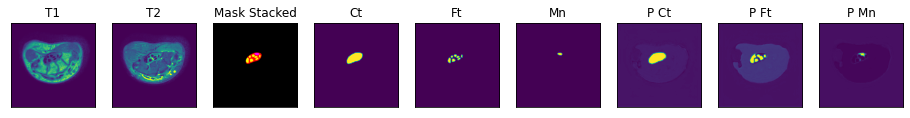

In [69]:
print('best mn dice')
# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)

In [70]:
x, y = testset[8]
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
# convert to tensor
image_tensor = transform(_x)
# take the first two images
image_tensor = image_tensor[0:2]
# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)
# cast to float
image_tensor = image_tensor.float()
if torch.cuda.is_available():
  image_tensor = image_tensor.cuda()
# fit model
model.eval()
pred = model(image_tensor)
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()
# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

worst mn dice


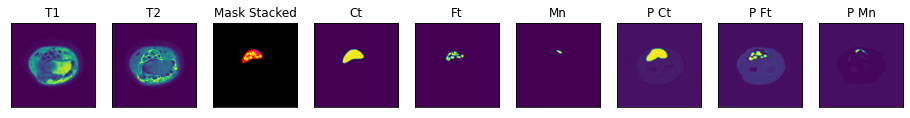

In [71]:
print('worst mn dice')
# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)

## evalute whole testset

In [72]:
testset_path = F"/content/gdrive/My Drive/ip_final/data/test"

testset = Dataset(
    testset_path,
    preprocessing = get_preprocessing_no_pretrain(),
)

In [73]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)

In [79]:
# evaluate model on test set
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 18/18 [00:01<00:00, 11.78it/s, dice_loss - 0.8231, iou_score - 0.7253]


## Draw contour

In [80]:
testset = Dataset(
    testset_path,
)

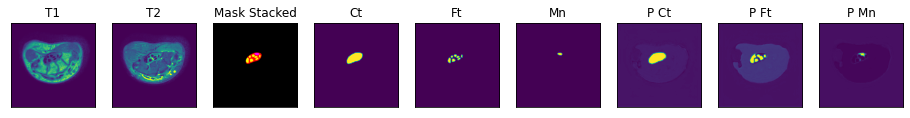

In [81]:
x, y = testset[4]
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
# convert to tensor
image_tensor = transform(_x)
# take the first two images
image_tensor = image_tensor[0:2]
# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)
# cast to float
image_tensor = image_tensor.float()
if torch.cuda.is_available():
  image_tensor = image_tensor.cuda()
# fit model
model.eval()
pred = model(image_tensor)
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()
# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)

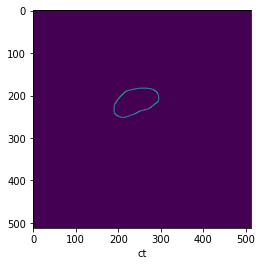

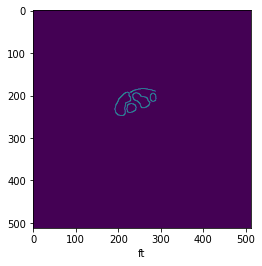

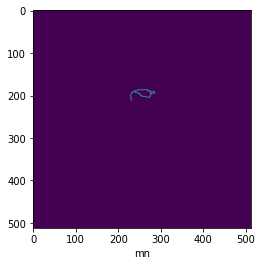

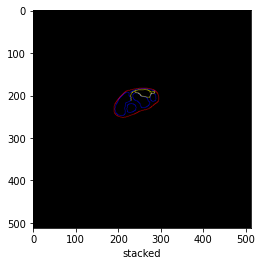

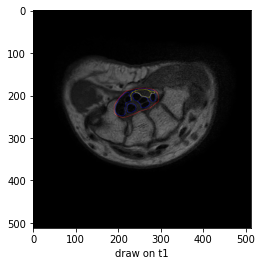

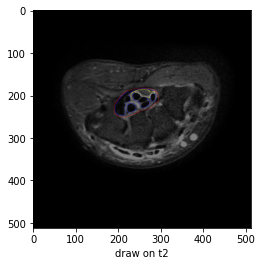

In [82]:
ct = (np_pred[..., 0] * 255).astype(np.uint8)
ft = (np_pred[..., 1] * 255).astype(np.uint8)
mn = (np_pred[..., 2] * 255).astype(np.uint8)

blurred = cv2.GaussianBlur(ct, (11, 11), 0)
binaryIMG_ct = cv2.Canny(blurred, 20, 160)
plt.figure(0)
plt.xlabel('ct')
plt.imshow(binaryIMG_ct)

blurred = cv2.GaussianBlur(ft, (11, 11), 0)
binaryIMG_ft = cv2.Canny(blurred, 20, 160)
plt.figure(1)
plt.xlabel('ft')
plt.imshow(binaryIMG_ft)

blurred = cv2.GaussianBlur(mn, (11, 11), 0)
binaryIMG_mn = cv2.Canny(blurred, 20, 160)
plt.figure(2)
plt.xlabel('mn')
plt.imshow(binaryIMG_mn)

plt.figure(3)
# ct red, mn yellow, ft blue
stacked = np.stack((binaryIMG_ct + binaryIMG_mn, binaryIMG_mn, binaryIMG_ft), axis=2)
plt.xlabel('stacked')
plt.imshow(stacked)

plt.figure(4)
clone_t1 = (x[...,0]*255).astype(np.uint8).copy()
clone_t1 = np.stack((clone_t1, clone_t1, clone_t1), axis=2)
draw_t1 = (clone_t1*0.5 + stacked*0.5).astype(np.uint8)
plt.xlabel('draw on t1')
plt.imshow(draw_t1)

plt.figure(5)
clone_t2 = (x[...,1]*255).astype(np.uint8).copy()
clone_t2 = np.stack((clone_t2, clone_t2, clone_t2), axis=2)
draw_t2 = (clone_t2*0.5 + stacked*0.5).astype(np.uint8)
plt.xlabel('draw on t2')
plt.imshow(draw_t2)